# Artificial Neural Network Mid Term Exam


**Student Information**
* Salaki Reynaldo Joshua
* 202228511
* Ph.D in Electronics Information and Communication Engineering
* Kangwon National University


**Description**

Collect data on your field of study and implement an artificial intelligence prediction model by utilizing the artificial intelligence model (classification or regression model) you have learned in this class.
  - Collecting data in your research field (Example: hydrogen data, renewable energy data, etc.)
  - Perform data preprocessing
  - Building a deep learning model
  - Check overfitting by graph
  - Automatic interruption of learning
  - Model training and prediction

# Diabetic Retinopathy

Diabetic retinopathy (DR) is the major ocular complication of diabetes mellitus,
and is a problem with significant global health impact. Major advances in
diagnostics, technology and treatment have already revolutionized how we
manage DR in the early part of the 21st century. For example, the accessibility of
imaging with optical coherence tomography, and the development of antivascular endothelial growth factor (VEGF) treatment are just some of the
landmark developments that have shaped the DR landscape over the last few
decades. Yet, there are still more exciting advances being made. Looking
forward to 2030, many of these ongoing developments are likely to further
transform the field. First, epidemiologic projections show that the global
burden of DR is not only increasing, but also shifting from high-income
countries towards middle- and low-income areas [1]

The below figure shows an example of a healthy patient and a patient with diabetic retinopathy as viewed by fundus photography ([source](https://www.biorxiv.org/content/biorxiv/early/2018/06/19/225508.full.pdf)):

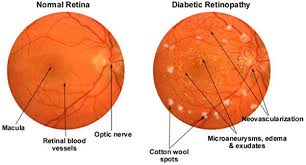

Figure 1. A healthy patient and a patient with diabetic retinopathy as viewed by fundus photography [2]



An automated tool for grading severity of diabetic retinopathy would be very useful for accerelating detection and treatment. Recently, there have been a number of attempts to utilize deep learning to diagnose DR and automatically grade diabetic retinopathy. This includes this [competition](https://kaggle.com/c/diabetic-retinopathy-detection) and [work by Google](https://ai.googleblog.com/2016/11/deep-learning-for-detection-of-diabetic.html). Even one deep-learning based system is [FDA approved](https://www.fda.gov/NewsEvents/Newsroom/PressAnnouncements/ucm604357.htm).

Clearly, this dataset and deep learning problem is quite well-characterized.

# A look at the data:

Data description:

>You are provided with a large set of high-resolution retina images taken under a variety of imaging conditions. A left and right field is provided for every subject. >Images are labeled with a subject id as well as either left or right (e.g. 1_left.jpeg is the left eye of patient id 1).
>
>A clinician has rated the presence of diabetic retinopathy in each image on a scale of 0 to 4, according to the following scale:
>
>0 - No DR
>
>1 - Mild
>
>2 - Moderate
>
>3 - Severe
>
>4 - Proliferative DR
>
>Your task is to create an automated analysis system capable of assigning a score based on this scale.

...

> Like any real-world data set, we will encounter noise in both the images and labels. Images may contain artifacts, be out of focus, underexposed, or overexposed. A major aim of this competition is to develop robust algorithms that can function in the presence of noise and variation.

For a simpler project, I will perform binary classification of Referrable Diabetic Retinopathy (RDR), which are cases with stage 2 or above. This sort of classification has been done in previous research, including Google's research paper as mentioned above.

## Preprocessing of the original dataset

The [original dataset](https://www.kaggle.com/c/diabetic-retinopathy-detection/data) is quite large (35 GB). Therefore, the data was significantly resized before being passed into the network. The data was downloaded onto a computer and cropped to get rid of as much black space as possible. This was done by applying a threshold to the images, find the largest contour, and finding the enclosing circle. This gives the circular mask. The radius of the circle is used as the width of the image, and the height is kept to maintain the aspect ratio, unless the it can be cropped without cropping out parts of the image:
```
# import the necessary packages
import numpy as np
import cv2
import glob
import os
from tqdm import tqdm
import math
from PIL import Image
files = glob.glob('D:\\Experiments with Deep Learning\\DR Kaggle\\train\\train\\train\\*.jpeg')

new_sz = 1024

def crop_image(image):
    output = image.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret,gray = cv2.threshold(gray,10,255,cv2.THRESH_BINARY)
    contours,hierarchy = cv2.findContours(gray,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        print('no contours!')
        flag = 0
        return image, flag
    cnt = max(contours, key=cv2.contourArea)
    ((x, y), r) = cv2.minEnclosingCircle(cnt)
    x = int(x); y = int(y); r = int(r)
    flag = 1
    #print(x,y,r)
    if r > 100:
        return output[0 + (y-r)*int(r<y):-1 + (y+r+1)*int(r<y),0 + (x-r)*int(r<x):-1 + (x+r+1)*int(r<x)], flag
    else:
        print('none!')
        flag = 0
        return image,flag


for i in tqdm(range(len(files))):
    img = cv2.imread(files[i])
    img_cropped, flag = crop_image(img)
    if not flag:
        print(files[i])
    height, width, _= img_cropped.shape
    ratio = height/width
    if width > new_sz:
        new_image = cv2.resize(img_cropped,(new_sz,math.ceil(new_sz*ratio)))  
    else:
        new_image = img_cropped
    cv2.imwrite('D:\\Experiments with Deep Learning\\DR Kaggle\\train\\train\\resized_train_cropped\\'+os.path.basename(files[i]),new_image)
 ```       
The folder `resized_train_cropped` contains the images, and `trainLabels_cropped.csv` contains the labels for the images.


**Reference :**

[1] Tien-En Tan, and Tien Yin Wong. 2023. Diabetic retinopathy: Looking
forward to 2030. Frontiers in Endocrinology. 13:1077669.
doi: 10.3389/fendo.2022.1077669

[2] Alexander Rakhlin. 2018. Diabetic Retinopathy detection through integration of Deep Learning classification framework.bioRxiv preprint doi:

# Import Library

In [ ]:
import os
files = os.listdir('../input/resized_train/resized_train')
print(len(files))

35126


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai import *
from fastai.vision import *
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
print('Make sure cuda is installed:', torch.cuda.is_available())
print('Make sure cudnn is enabled:', torch.backends.cudnn.enabled)

Make sure cuda is installed: True
Make sure cudnn is enabled: True


# Reading data
Here we will open the dataset with pandas, check distribution of labels, and oversample to reduce imbalance.

In [ ]:
base_image_dir = os.path.join('..', 'input')
df = pd.read_csv(os.path.join(base_image_dir, 'trainLabels_cropped.csv'))
df['path'] = df['image'].map(lambda x: os.path.join(base_image_dir,'resized_train_cropped/resized_train_cropped','{}.jpeg'.format(x)))
df = df.drop(columns=['image'])
df = df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
df['level'] = (df['level'] > 1).astype(int) # Disease or no disease
df.head(10)

,Unnamed: 0,Unnamed: 0.1,level,path
0,4094,4098,0,../input/resized_train_cropped/resized_train_c...
1,8004,8010,0,../input/resized_train_cropped/resized_train_c...
2,34837,34854,0,../input/resized_train_cropped/resized_train_c...
3,18585,18597,1,../input/resized_train_cropped/resized_train_c...
4,579,579,0,../input/resized_train_cropped/resized_train_c...
5,6078,6082,0,../input/resized_train_cropped/resized_train_c...
6,13154,13163,0,../input/resized_train_cropped/resized_train_c...
7,796,797,0,../input/resized_train_cropped/resized_train_c...
8,2413,2416,0,../input/resized_train_cropped/resized_train_c...
9,7232,7236,0,../input/resized_train_cropped/resized_train_c...


**Note:** The dataset is highly imbalanced, with many samples with no disease:

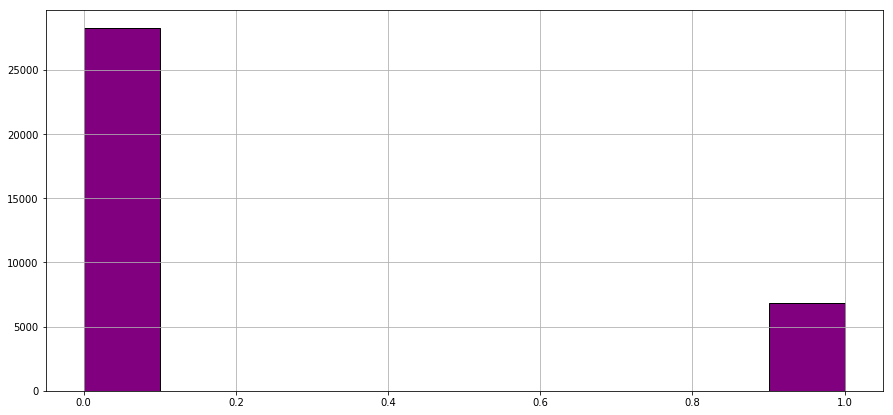

In [ ]:
df['level'].hist(color="purple", edgecolor= 'black',figsize = (15, 7))

In [ ]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df,test_size=0.2) # Here we will perform an 80%/20% split of the dataset, with stratification to keep similar distribution in validation set

7022

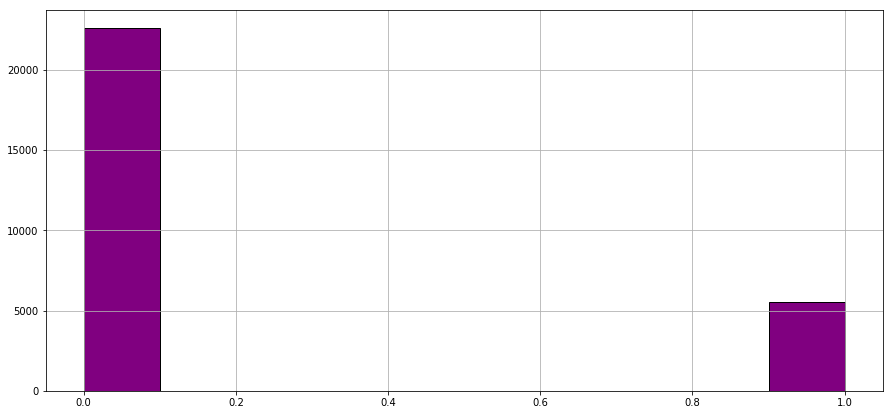

In [ ]:
train_df['level'].hist(color="purple", edgecolor= 'black',figsize = (15, 7))
len(val_df)

In [ ]:
df = pd.concat([train_df,val_df]) #beginning of this dataframe is the training set, end is the validation set
len(df)

35108

In [ ]:
bs =16 #smaller batch size is better for training, but may take longer
sz=512

# Load Dataset

Here, we will load the dataset into the `ImageItemList` class provided by `fastai`. The fastai library also implements various transforms for data augmentation to improve training. While there are some defaults that I leave intact, I add vertical flipping (`do_flip=True`) as this has been commonly used for this particular problem.

Typically, one would use the `ImageDataBunch` class to load the dataset much easier, but as I will adjust the splitting and add oversampling in future kernels, I have used this customized creation of the DataBunch using the `data_block` API.

In [ ]:
tfms = get_transforms(do_flip=True,flip_vert=True,max_rotate=360,max_warp=0,max_zoom=1.0,max_lighting=0.1,p_lighting=0.5)
src = (ImageList.from_df(df=df,path='./',cols='path') #get dataset from dataset
        .split_by_idx(range(len(train_df)-1,len(df))) #Splitting the dataset
        .label_from_df(cols='level') #obtain labels from the level column
      )
data= (src.transform(tfms,size=sz,resize_method=ResizeMethod.SQUISH,padding_mode='zeros') #Data augmentation
        .databunch(bs=bs,num_workers=4) #DataBunch
        .normalize(imagenet_stats) #Normalize
       )

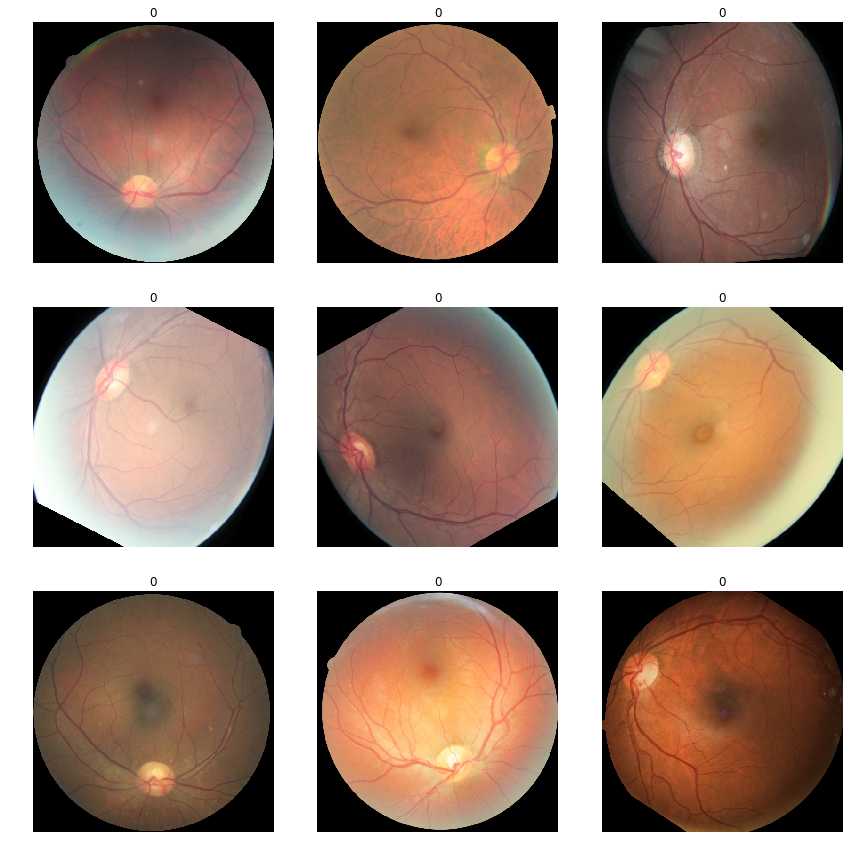

In [ ]:
data.show_batch(rows=3, figsize=(12,12))

In [ ]:
print(data.classes)
len(data.classes),data.c

[0, 1]


(2, 2)

# Training (Transfer learning)

**Training:**

We use transfer learning, where we retrain the last layers of a pretrained neural network. I use the ResNet50 architecture trained on the ImageNet dataset, which has been commonly used for pre-training applications in computer vision. Fastai makes it quite simple to create a model and train:

In [ ]:
import torchvision
from fastai.metrics import *
from fastai.callbacks import *
learn = cnn_learner(data, models.resnet50, wd = 1e-5, metrics = [accuracy,AUROC()],callback_fns=[partial(CSVLogger,append=True)])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:00<00:00, 143534665.67it/s]


We use the learning-rate finder developed by Dr. Leslie Smith and implemented by the fastai team in their library:

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 9.12E-07
Min loss divided by 10: 3.98E-03


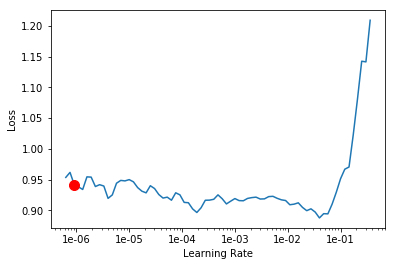

In [ ]:
learn.recorder.plot(suggestion=True)

Here we can see that the loss decreases fastest around `lr=1e-2` so that is what we will use to train:

In [ ]:
learn.fit_one_cycle(1,max_lr = 1e-2)

epoch,train_loss,valid_loss,accuracy,auroc,time
0,0.300815,0.289540,0.890645,0.892545,26:23


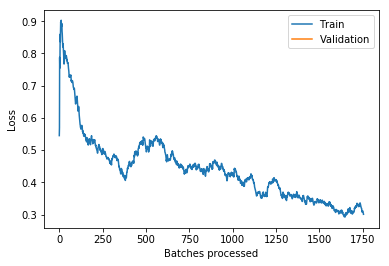

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save('stage-1-512')

The previous model only trained the last model. We can unfreeze the rest of the model, and train the rest of the model using discriminative learning rates. The first layers aren't changed as much, with lower learning rates, while the last layers are changed more, with higher learning rates. We use the learning rate finder again, and use a range of learning rates for different layers in the neural network.

In [ ]:
learn.load('stage-1-512')

Learner(data=ImageDataBunch;

Train: LabelList (28085 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
0,0,0,1,0
Path: .;

Valid: LabelList (7023 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
1,0,0,0,0
Path: .;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1,

In [ ]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


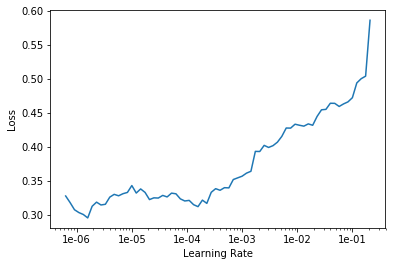

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(16, max_lr=slice(1e-6,1e-3))

epoch,train_loss,valid_loss,accuracy,auroc,time
0,0.309796,0.287437,0.892638,0.898791,27:32
1,0.292138,0.266092,0.899046,0.907896,27:36
2,0.314994,0.264474,0.899331,0.909767,27:41
3,0.308940,0.281859,0.893635,0.905164,27:44
4,0.307807,0.258364,0.903887,0.920777,27:45
5,0.311770,0.246806,0.907732,0.925023,27:47
6,0.251889,0.229282,0.912715,0.933077,27:44
7,0.250837,0.236006,0.910295,0.934041,27:42
8,0.278792,0.227283,0.916987,0.937943,27:40
9,0.276880,0.219994,0.918696,0.938203,27:42


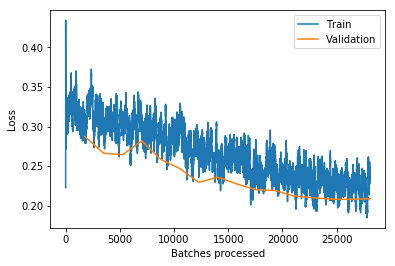

In [ ]:
learn.recorder.plot_losses()

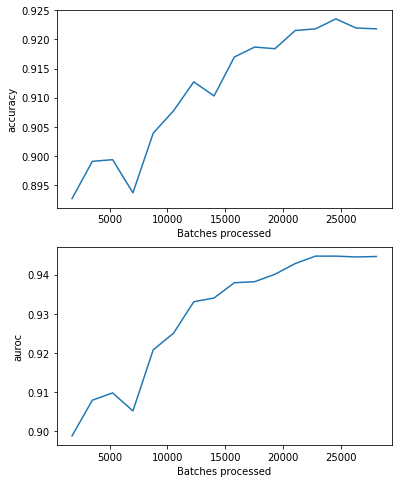

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
learn.save('stage-2-512')

# Checking results

We look at our predictions and make a confusion matrix.

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

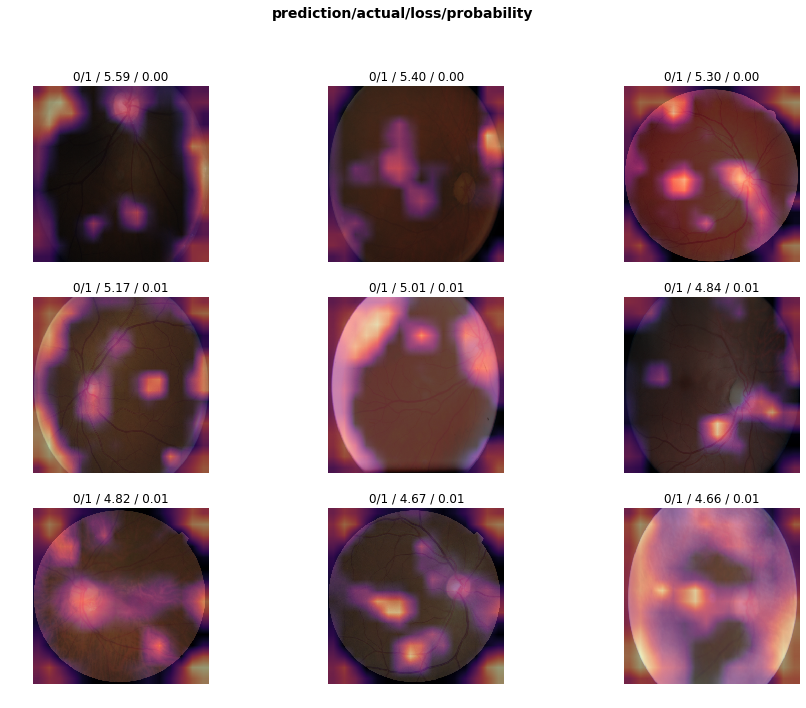

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))

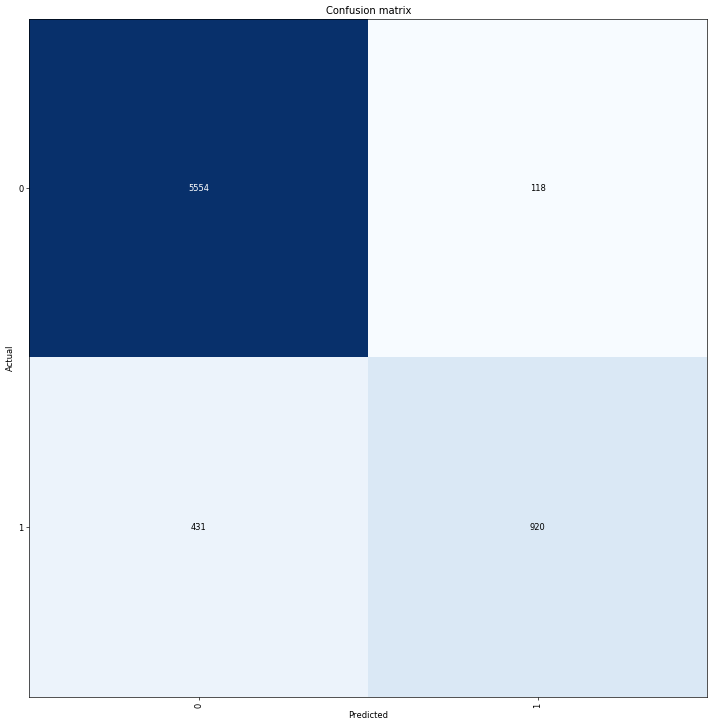

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
from sklearn.metrics import roc_auc_score, confusion_matrix
def auc_score(y_score,y_true):
    try:
      auc = torch.tensor(roc_auc_score(y_true,y_score[:,1]))
    except:
      auc = torch.tensor(np.nan)
    return auc

probs,val_labels = learn.get_preds(ds_type=DatasetType.Valid)
print('Accuracy',accuracy(probs,val_labels)),
print('Error Rate', error_rate(probs, val_labels))
print('AUC', auc_score(probs,val_labels))


tn, fp, fn, tp = confusion_matrix(val_labels,(probs[:,1]>0.5).float()).ravel()

specificity = tn/(tn+fp)
sensitivity = tp/(tp+fn)

print('Specificity and Sensitivity',specificity,sensitivity)

Accuracy tensor(0.9218)
Error Rate tensor(0.0782)
AUC tensor(0.9446)
Specificity and Sensitivity 0.9791960507757405 0.6809770540340488


Our model has decent AUC (around 0.92), which is similar to some of the [results](https://arxiv.org/abs/1803.04337) demonstrated previously. However, this is still not close to AUC=0.99 demonstrated by Google.

We can use an optimized threshold as well:

In [ ]:
from sklearn.metrics import roc_curve
def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------
    list type, with optimal cutoff value

    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr))
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold'])


print(probs[:,1])

threshold = Find_Optimal_Cutoff(val_labels,probs[:,1])
print(threshold)

print(confusion_matrix(val_labels,probs[:,1]>threshold[0]))

tn, fp, fn, tp = confusion_matrix(val_labels,probs[:,1]>threshold[0]).ravel()

specificity = tn/(tn+fp)
sensitivity = tp/(tp+fn)

print('Specificity and Sensitivity',specificity,sensitivity)

tensor([0.9883, 0.0116, 0.0209,  ..., 0.0086, 0.0051, 0.1310])
[0.13500292599201202]
[[4934  738]
 [ 176 1175]]
Specificity and Sensitivity 0.8698871650211566 0.8697261287934863


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


We will now export our model so it can be used for inference.

In [ ]:
learn.export()